# Interpretability

- Data load and preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

dfFeature = pd.read_csv(r'pruebaData.csv')
dfFeature.drop(columns=['Complain'], inplace= True)



X = dfFeature.drop('Exited', axis=1)
y = dfFeature['Exited']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=42)

- Logistic Regression

In [2]:
# Scale the data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
logistic_model = LogisticRegression(solver='saga', max_iter=5000) 
logistic_model.fit(X_train_scaled, y_train)

# Evaluate Logistic Regression
logistic_score = logistic_model.score(X_test_scaled, y_test)
print(f"Logistic Regression Accuracy: {logistic_score}")

# Feature Importance for Logistic Regression
coefs_log = logistic_model.coef_
intercept_log = logistic_model.intercept_
coef_df = pd.DataFrame({'feature': X_train.columns.values, 'coef': coefs_log[0]})

stdv = np.std(X_train, 0)
feature_importance_log = abs(coefs_log.reshape(X_train.shape[1],) * stdv).sort_values(ascending=False)
print("\nLogistic Regression Feature Importance:")
print(feature_importance_log)

Logistic Regression Accuracy: 0.8366666666666667

Logistic Regression Feature Importance:
Balance               1640.974848
EstimatedSalary        138.586566
Point Earned            10.722013
CreditScore              5.427433
IsActiveMember           0.239498
NumOfProducts            0.219602
Age_30-40                0.161687
Tenure                   0.161665
Age_<30                  0.142403
Age_50-60                0.139616
Age_40-50                0.121663
Geography_Germany        0.109274
Geography_France         0.070478
Gender_Male              0.067794
Gender_Female            0.067794
Age_>60                  0.042812
Geography_Spain          0.038796
Satisfaction Score       0.023236
Card Type_DIAMOND        0.021328
Card Type_GOLD           0.019945
HasCrCard                0.011565
Card Type_SILVER         0.001279
Card Type_PLATINUM       0.000103
dtype: float64


- Decision Tree


Decision Tree Accuracy: 0.84
ROC AUC Score: 0.7743691457634037


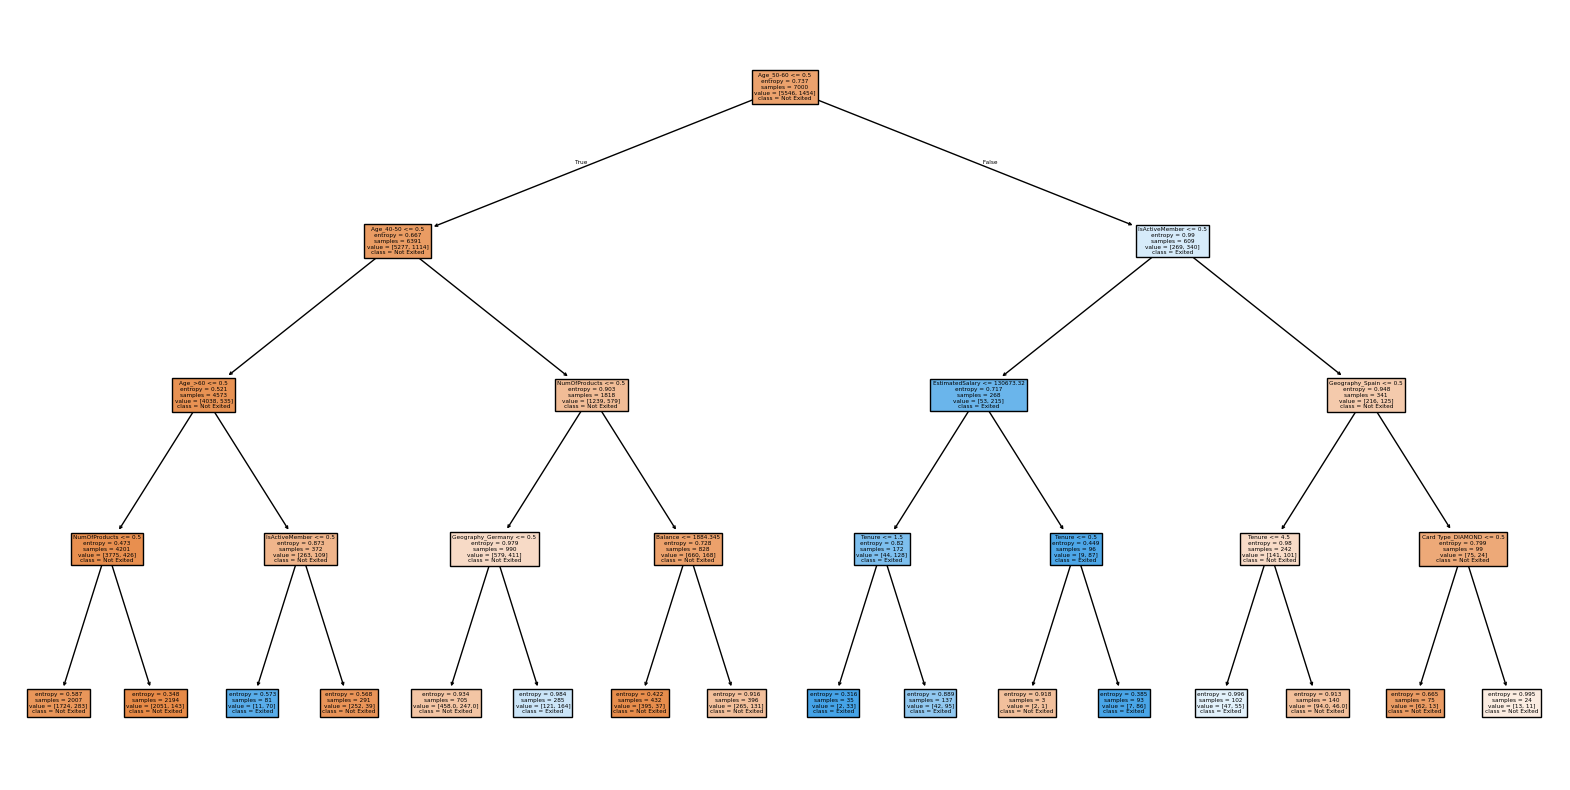


Decision Tree Feature Importance:
               feature  importance
20           Age_50-60    0.277364
19           Age_40-50    0.232383
5       IsActiveMember    0.190969
3        NumOfProducts    0.112102
22             Age_>60    0.064315
2              Balance    0.055006
12   Geography_Germany    0.028887
1               Tenure    0.019557
6      EstimatedSalary    0.007702
13     Geography_Spain    0.006631
14   Card Type_DIAMOND    0.005083
4            HasCrCard    0.000000
0          CreditScore    0.000000
10         Gender_Male    0.000000
7   Satisfaction Score    0.000000
11    Geography_France    0.000000
8         Point Earned    0.000000
9        Gender_Female    0.000000
15      Card Type_GOLD    0.000000
18           Age_30-40    0.000000
17    Card Type_SILVER    0.000000
16  Card Type_PLATINUM    0.000000
21             Age_<30    0.000000


In [3]:
# Decision Tree
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)  
decision_tree.fit(X_train, y_train)

# Evaluate Decision Tree
decision_tree_score = decision_tree.score(X_test, y_test)
print(f"\nDecision Tree Accuracy: {decision_tree_score}")

# ROC
y_proba = decision_tree.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc}")


# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, filled=True, feature_names=X.columns, class_names=['Not Exited', 'Exited'])
plt.show()

# Feature Importance for Decision Tree
dt_imp_df = pd.DataFrame({'feature': X_train.columns.values.tolist(), 'importance': decision_tree.feature_importances_}).sort_values(by='importance', ascending=False)
print("\nDecision Tree Feature Importance:")
print(dt_imp_df)